<div class="alert alert-block alert-success">
    <h1 align="center">Scikit-Learn Tips</h1>
    <h3 align="center">Tip 16 : Creating custom scikit-learn Transformers</h3>
    <h4 align="center"><a href="http://www.iran-machinelearning.ir">Soheil Tehranipour</a></h5>
</div>


# Creating a Custom Transformer
In scikit-learn, Transformers are objects that transform a dataset into a new one to prepare the dataset for predictive modeling, e.g., scaling numeric values, one-hot encoding categoricals, etc.

While scikit-learn has many Transformers, it's often helpful to create our own. This post will look at three ways to make your own Custom Transformers: Creating a Custom Transformer from scratch, using the FunctionTransformer, and subclassing an existing Transformer.

* This method defines a custom transformer by inheriting BaseEstimator and TransformerMixin classes of Scikit-Learn.
*‘BaseEstimator’ class of Scikit-Learn enables hyperparameter tuning by adding the ‘set_params’ and ‘get_params’ methods. 
* While, ‘TransformerMixin’ class adds the ‘fit_transform’ method without explicitly defining it.

In [1]:
!pip install -U scikit-learn

In [23]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

#Data Import
data = pd.DataFrame(load_iris()['data'],columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [24]:
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X,y=None):
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None):
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
            X.iloc[:, i] = x
        return X
    
outlier_remover = OutlierRemover()

In [25]:
test = pd.DataFrame({'col1':[100,200,300,999],'col2':[0,0,1,2],'col3':[-10,0,1,2]})
test

,col1,col2,col3
0,100,0,-10
1,200,0,0
2,300,1,1
3,999,2,2


In [26]:
outlier_remover.fit(test)

OutlierRemover()

In [27]:
outlier_remover.transform(test)

,col1,col2,col3
0,100.0,0,NaN
1,200.0,0,0.0
2,300.0,1,1.0
3,NaN,2,2.0


In [28]:
outlier_remover.fit_transform(test)

,col1,col2,col3
0,100.0,0,NaN
1,200.0,0,0.0
2,300.0,1,1.0
3,NaN,2,2.0


In [29]:
outlier_remover_100 = OutlierRemover(factor=100)
outlier_remover_100.fit_transform(test)

,col1,col2,col3
0,100,0,-10
1,200,0,0
2,300,1,1
3,999,2,2


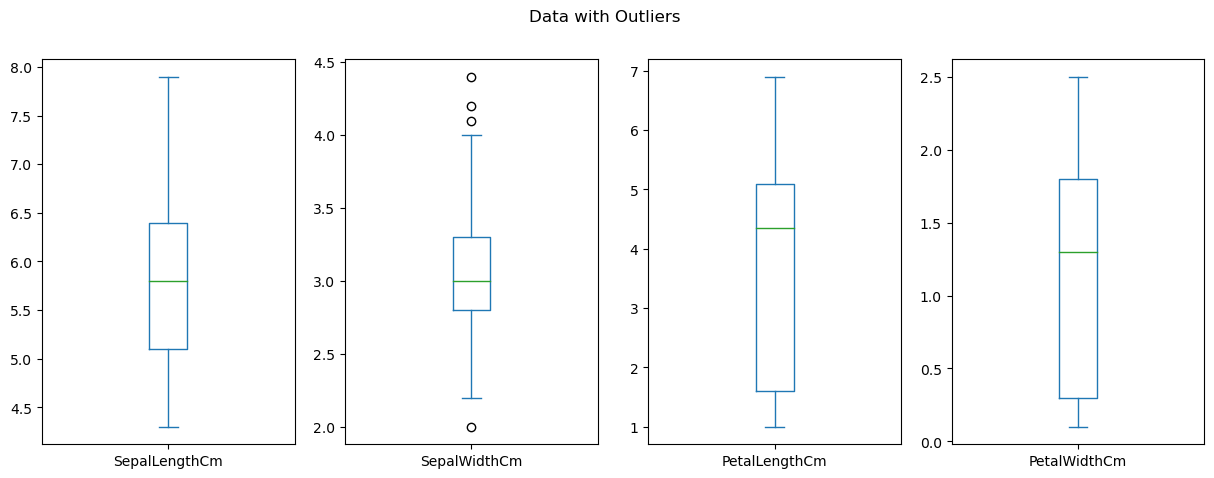

In [30]:
data.plot(kind="box",subplots=True,figsize=(15,5),title="Data with Outliers");

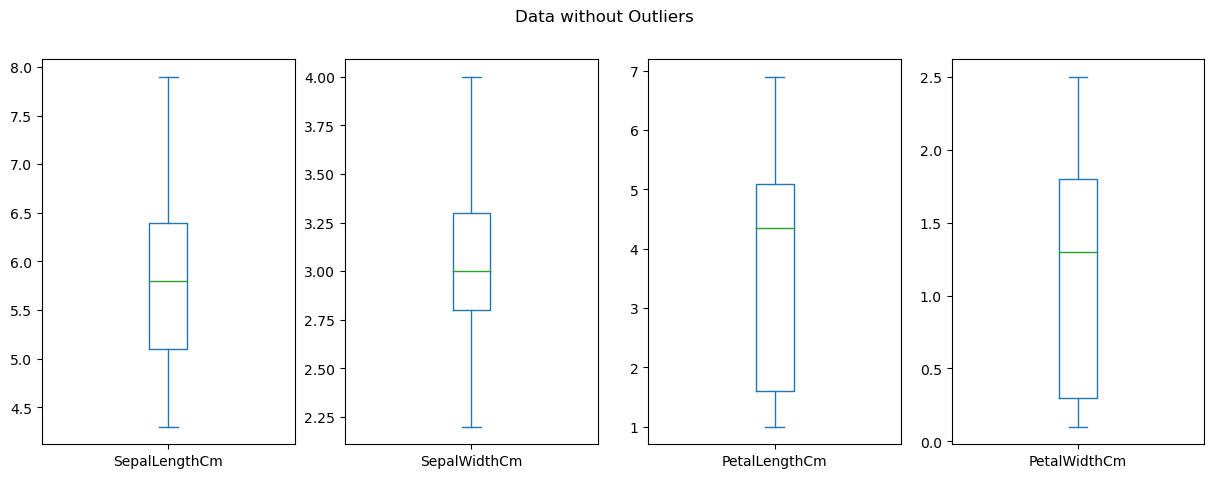

In [31]:
outlier_remover = OutlierRemover()

#ColumnTransformer to remove outliers
ct = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(),list(range(data.shape[1]))]],remainder='passthrough')

#iris data after outlier removal
data_without_outliers = pd.DataFrame(ct.fit_transform(data),columns=data.columns)

#iris data box plot after outlier removal
data_without_outliers.plot(kind="box",subplots=True,figsize=(15,5),title="Data without Outliers");

In [32]:
# 4 outliers are removed from SepalWidthCm, other columns stayed the same as they have no outliers.
data_without_outliers.isnull().sum()

SepalLengthCm    0
SepalWidthCm     4
PetalLengthCm    0
PetalWidthCm     0
dtype: int64

In [33]:
#outliers removed from sepal width (cm)
list(data.loc[data_without_outliers.isnull().sum(axis=1)>0,'SepalWidthCm'])

[4.4, 4.1, 4.2, 2.0]

In [34]:
X = data.copy()
y = load_iris()['target'].copy()

#Pipeline with outlier remover, imputer and regressor
pipeline = Pipeline(steps=[['outlier_removal',ct],['imputer',SimpleImputer()],['regressor',LogisticRegression(max_iter=1000)]]) 

param_grid = {'outlier_removal__outlier_remover__factor':[0,1,2,3,4],
              'imputer__strategy':['mean','median','most_frequent'],
              'regressor__C':[0.01,0.1,1,10,100]}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=3)

gs.fit(X,y)

gs.best_params_

{'imputer__strategy': 'mean',
 'outlier_removal__outlier_remover__factor': 2,
 'regressor__C': 1}

## References:
1. https://sklearn-template.readthedocs.io/en/latest/user_guide.html
2. https://www.andrewvillazon.com/custom-scikit-learn-transformers/
3. https://amueller.github.io/aml/05-advanced-topics/14-custom-estimators.html
    

<img src="https://webna.ir/wp-content/uploads/2018/08/%D9%85%DA%A9%D8%AA%D8%A8-%D8%AE%D9%88%D9%86%D9%87.png" width=50% />